## 1.) Load image
Load image and mask as third channel, setup threshold on mask where each number below 127 is zero and 255 otherwise


Image shape: (540, 540)


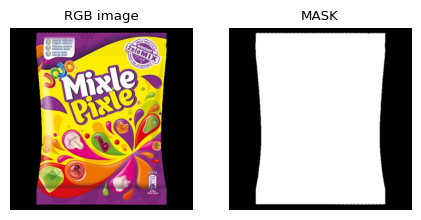

In [16]:
import os
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt


image_path = r"data/resources/470.png" # Image path
image_array = cv2.imread(image_path, -1) # load image with alpha (-1) for load all channels with alpha
image_array_bgr = image_array[:, : , :3] # Load BGR image, default it's BGR
image_array_rgb = cv2.cvtColor(image_array_bgr, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
image_array_mask = image_array[:, :, -1] # Mask from PNG
image_array_mask_thresh = np.where(image_array_mask <= 200, 0, 255).astype(np.uint8) # Setup threshold


kernel = np.ones((5,5), np.uint8)
image_array_mask_thresh_blur = cv2.erode(image_array_mask_thresh, kernel, iterations=1)

image_array_mask_thresh_blur = cv2.GaussianBlur(image_array_mask_thresh_blur, (3, 3), 0, 0, cv2.BORDER_DEFAULT)

image_array_mask_thresh = cv2.bitwise_and(image_array_mask_thresh, image_array_mask_thresh_blur)

cv2.imwrite("mask.jpg", image_array_mask_thresh)



image_array_rgb = cv2.bitwise_and(image_array_rgb, image_array_rgb, mask=image_array_mask_thresh)

plt.figure(figsize=(8, 16))
plt.rcParams.update({'font.size': 8})
plt.subplot(1, 3, 1)
plt.imshow(image_array_rgb)
plt.title("RGB image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(image_array_mask_thresh, cmap="gray")
plt.title("MASK")
plt.axis("off")

print(f"Image shape: {image_array_mask_thresh.shape}")

# cv2.imwrite("example.jpg",np.hstack((image_array_mask_thresh, eroded_img)))

## 2.) Create polygon
Create polygon from image mask resource [link](https://github.com/hazirbas/coco-json-converter/blob/master/generate_coco_json.py) and draw contour on RGB image


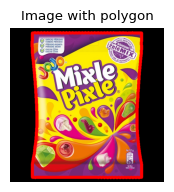

In [17]:
def polygon_from_mask(masked_array):
    """The function return polygon from mask"""
    contours, _ = cv2.findContours(masked_array, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    segmentation = []
    valid_poly = 0
    for c, contour in enumerate(contours):
        if contour.size >= 6: # Valid polygons have >= 6 coordinates (3 points)
            segmentation.append(contour.astype(float).flatten().tolist())
            valid_poly += 1
    if valid_poly == 0:
        raise ValueError
    return segmentation

polygon_list = polygon_from_mask(image_array_mask_thresh) # Get polygon coordinates list [x1,y1,x2,y2]
polygon_array = np.array(polygon_list[0], dtype=np.int32).reshape((-1, 2)) # Reshape to 2D matrix 1st col X 2nd col Y 

pts = polygon_array.reshape((-1, 1, 2)) # Reshape poolygon array to 3rd dimension
image_array_rgb_copy = image_array_rgb.copy() 
cv2.polylines(image_array_rgb_copy, [pts], isClosed=True, color=(255, 0, 0), thickness=10) # Draw polygon

plt.figure(figsize=(2, 2))
plt.imshow(image_array_rgb_copy)
plt.title("Image with polygon")
plt.axis(False)
plt.show()

## 3.) Cut image
Cut MASK with polygon coordinates, calculate new polygon values and draw RGB with new polygon

Image shape: (508, 384, 3)


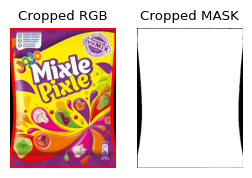

In [18]:
(min_x, min_y), (max_x, max_y) = np.min(polygon_array, axis=0), np.max(polygon_array, axis=0) # Calculate MIN/MAX values for cut 
image_rgb_crop = image_array_rgb[min_y: max_y, min_x: max_x] # Crop RGB image 
image_mask_crop = image_array_mask_thresh[min_y: max_y, min_x: max_x] # Crop MASK

polygon_list_crop = polygon_from_mask(image_mask_crop) # Get polygon coordinates list [x1,y1,x2,y2]
polygon_array_crop = np.array(polygon_list_crop[0], dtype=np.int32).reshape((-1, 2)) # Reshape to 2D matrix 1st col X 2nd col Y 

pts = polygon_array_crop.reshape((-1, 1, 2)) # Reshape poolygon array to 3rd dimension
image_rgb_crop_copy = image_rgb_crop.copy() 
cv2.polylines(image_rgb_crop_copy, [pts], isClosed=True, color=(255, 0, 0), thickness=10) # Draw polygon


plt.figure(figsize=(3, 8))
plt.rcParams.update({'font.size': 8})
plt.subplot(1, 2, 1)
plt.imshow(image_rgb_crop_copy)
plt.title("Cropped RGB")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(image_mask_crop, cmap="gray")
plt.title("Cropped MASK")
plt.axis("off")
print(f"Image shape: {image_rgb_crop.shape}")

## 4.) Rotate image
Rotate cropped image with cutom angle and expands image to avoid cropping

Image shape: (508, 384, 3)


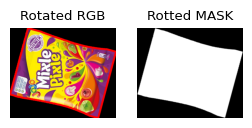

In [19]:
from library.utils import rotate_image

image_rgb_rotate = rotate_image(image_rgb_crop, 75) # Rotate RGB image
image_mask_rotate = rotate_image(image_mask_crop, 75) # Rotate MASK

polygon_list_rotate = polygon_from_mask(image_mask_rotate) # Get polygon coordinates list [x1,y1,x2,y2]
polygon_array_rotate = np.array(polygon_list_rotate[0], dtype=np.int32).reshape((-1, 2)) # Reshape to 2D matrix 1st col X 2nd col Y 

pts = polygon_array_rotate.reshape((-1, 1, 2)) # Reshape poolygon array to 3rd dimension
image_rgb_rotate_copy = image_rgb_rotate.copy() 
cv2.polylines(image_rgb_rotate_copy, [pts], isClosed=True, color=(255, 0, 0), thickness=10) # Draw polygon

plt.figure(figsize=(3, 8))
plt.rcParams.update({'font.size': 8})
plt.subplot(1, 2, 1)
plt.imshow(image_rgb_rotate_copy)
plt.title("Rotated RGB")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(image_mask_rotate, cmap="gray")
plt.title("Rotted MASK")
plt.axis("off")
print(f"Image shape: {image_rgb_crop.shape}")

## 5.) Place image
Place the image on top of the other [link](https://stackoverflow.com/questions/35783062/opencv-python-copy-polygon-from-one-image-to-another)
**NOTE:** For demonstration purposes

In [20]:
background_array = cv2.imread('data/resources/table.jpg') # Load background image
background_array = cv2.resize(background_array, (2000, 2000), interpolation=cv2.INTER_AREA) # Resize image (width, height)

(min_x, min_y), (max_x, max_y) = np.min(polygon_array_rotate, axis=0), np.max(polygon_array_rotate, axis=0) # Calculate MIN/MAX values for cut 
roi = background_array[min_y: max_y, min_x: max_x] # Cut ROI from background (Coordinates for CUT)
mask = image_mask_rotate[min_y: max_y, min_x: max_x] # Caut MASK same as ROI from image mask

# cv2.imwrite("mask2.jpg", mask)

mask_inv = 255 - mask # Invert mask
mask_inv = mask_inv.astype("float32") / 255
mask_inv = cv2.cvtColor(mask_inv, cv2.COLOR_GRAY2BGR)
# img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv) # 
# img_bg = cv2.multiply(roi.astype("float32"), mask_inv) # 
# img_bg = img_bg.astype("uint8")
# plt.imshow(img_bg)

src_cut = image_rgb_rotate[min_y: max_y, min_x: max_x]


alpha_mask = mask # Invert mask
alpha_mask = alpha_mask.astype("float32") / 255
alpha_mask = cv2.cvtColor(alpha_mask, cv2.COLOR_GRAY2BGR)
composite = roi * (1 - alpha_mask) + src_cut * alpha_mask

# dst = cv2.add(img_bg, src_cut)
# dst = cv2.bitwise_or(img_bg, src_cut)

final = background_array.copy()
final[min_y: max_y, min_x: max_x] = composite

cv2.imwrite("final.jpg", cv2.cvtColor(final, cv2.COLOR_BGR2RGB))

True

In [21]:
def rotate_image(mat, angle):
    """Rotates an image (angle in degrees) """
    height, width = mat.shape[: 2]  # image shape has 3 dimensions
    image_center = (width / 2, height / 2)

    # rotation_mat = cv2.getRotationMatrix2D(image_center, angle, randint(8, 12) / 10.)
    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0, 0])
    abs_sin = abs(rotation_mat[0, 1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to orig and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w / 2 - image_center[0]
    rotation_mat[1, 2] += bound_h / 2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

### Added composite in script

In [22]:
import cv2
import numpy as np

background = cv2.imread(r"C:\Users\Martin\Desktop\GroceriesPNG\data\backgrounds\IMG_20230317_103407.jpg", cv2.IMREAD_UNCHANGED)
overlay = cv2.imread(r"C:\Users\Martin\Desktop\GroceriesPNG\data\resources\470.png", cv2.IMREAD_UNCHANGED)
overlay = rotate_image(overlay, angle=45)

# separate the alpha channel from the color channels
alpha_channel = overlay[:, :, 3] / 255 # convert from 0-255 to 0.0-1.0
overlay_colors = overlay[:, :, :3]

# To take advantage of the speed of numpy and apply transformations to the entire image with a single operation
# the arrays need to be the same shape. However, the shapes currently looks like this:
#    - overlay_colors shape:(width, height, 3)  3 color values for each pixel, (red, green, blue)
#    - alpha_channel  shape:(width, height, 1)  1 single alpha value for each pixel
# We will construct an alpha_mask that has the same shape as the overlay_colors by duplicate the alpha channel
# for each color so there is a 1:1 alpha channel for each color channel
alpha_mask = np.dstack((alpha_channel, alpha_channel, alpha_channel))

# The background image is larger than the overlay so we'll take a subsection of the background that matches the
# dimensions of the overlay.
# NOTE: For simplicity, the overlay is applied to the top-left corner of the background(0,0). An x and y offset
# could be used to place the overlay at any position on the background.
h, w = overlay.shape[:2]
background_subsection = background[0:h, 0:w]

# combine the background with the overlay image weighted by alpha
composite = background_subsection * (1 - alpha_mask) + overlay_colors * alpha_mask

# overwrite the section of the background image that has been updated
background[0:h, 0:w] = composite

cv2.imwrite('combined.png', background)

True

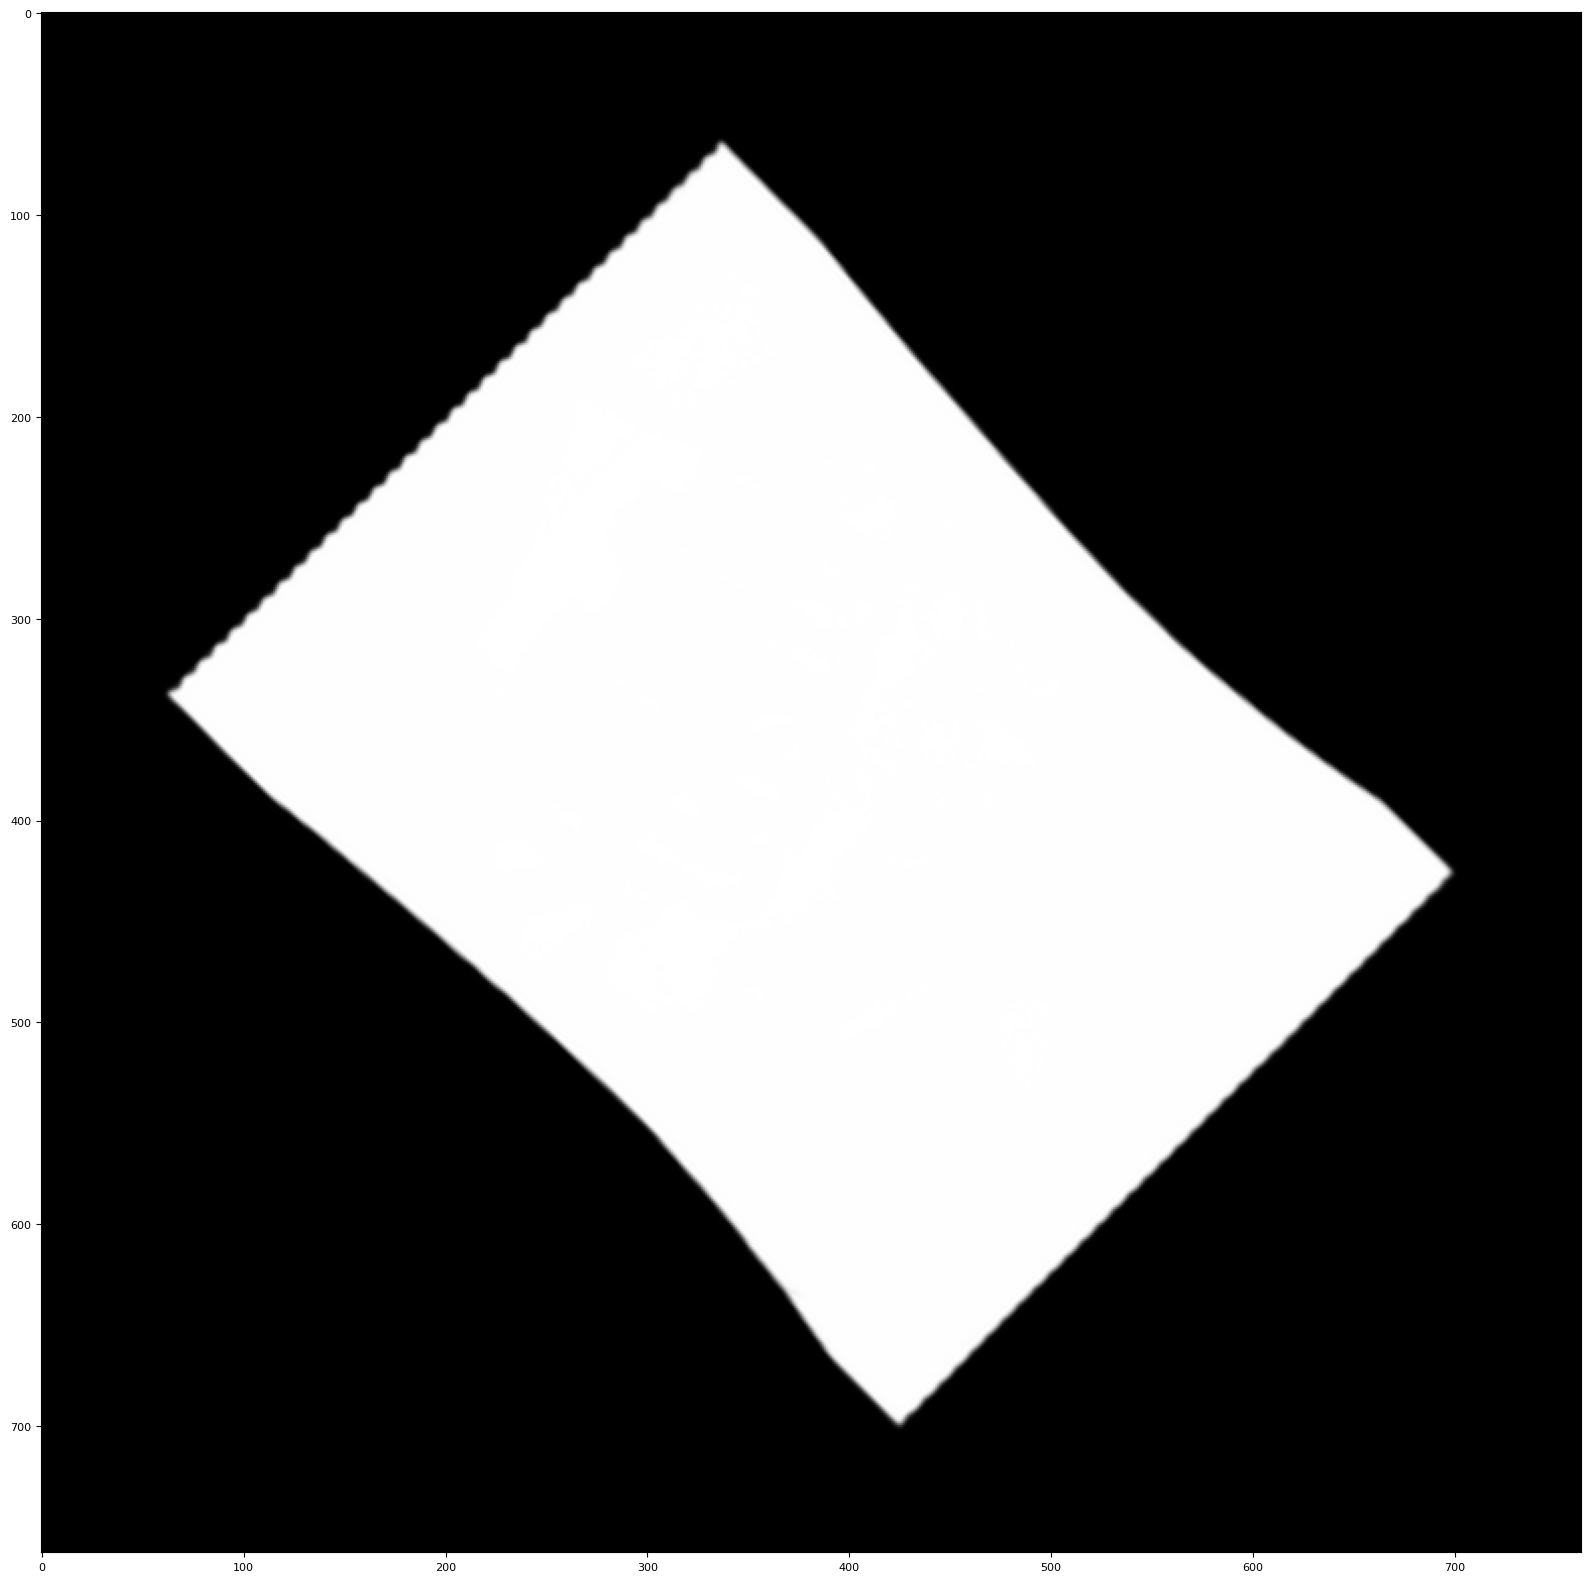

In [13]:
plt.figure(figsize=(20,20))
plt.imshow(alpha_mask)

In [24]:
from rembg import remove
from PIL import Image



In [29]:
import os

input_path = r"C:\Users\Martin\Desktop\Realsense\data\rgb"
output_path = r'C:\Users\Martin\Desktop\out'

for img in os.listdir(input_path):
    input_img_path = input_path + os.sep + img
    output_img_path = output_path + os.sep + img.split(".")[0] + ".png"
    input_img = Image.open(input_img_path)
    output = remove(input_img)
    output.save(output_img_path)

In [27]:
import cv2

img = cv2.imread(r"C:\Users\Martin\Desktop\GroceriesPNG\data\our\IMG-100-0353.png", -1)

img.shape[-1] == 4

(720, 1000, 4)